OK, so we can solve Semantle in a Euclidean space after doing PCA to it.
But our signal is actually cosine distance in a word-vector space. 

How well does that translate exactly? Bigger cos dist = bigger euclidean distance probably.
But how noisy will it be? Does using more PCA components denoise this sufficiently? Let's hope so!

In [1]:
import dataclasses
import pickle
import random
import numpy as np

from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize
from gensim import models

from matplotlib import pyplot as plt
from typing import *

In [2]:
"""
def read_glove_file() -> Dict[str, List[float]]:
    #Yields the next 'size' vectors in a glove file.
    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'
    w_vecs = {}
    with tqdm(total=400000) as pbar:
        with open(glove_file) as fh:
            for line in fh.readlines():
                pbar.update(1)
                toks = line.strip().split()
                word = toks[0]
                # non-words like punctuation marks have entries, but we don't want those
                if not word.isalnum():  
                    continue
                # Some bigrams and trigrams are in the dataset. Skip those.
                try:
                    float(toks[1])
                except ValueError:
                    continue
                # No errors, parse the line.
                vec = [float(s) for s in toks[1:]]
                w_vecs[word] = vec
    return w_vecs
"""

"\ndef read_glove_file() -> Dict[str, List[float]]:\n    #Yields the next 'size' vectors in a glove file.\n    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'\n    w_vecs = {}\n    with tqdm(total=400000) as pbar:\n        with open(glove_file) as fh:\n            for line in fh.readlines():\n                pbar.update(1)\n                toks = line.strip().split()\n                word = toks[0]\n                # non-words like punctuation marks have entries, but we don't want those\n                if not word.isalnum():  \n                    continue\n                # Some bigrams and trigrams are in the dataset. Skip those.\n                try:\n                    float(toks[1])\n                except ValueError:\n                    continue\n                # No errors, parse the line.\n                vec = [float(s) for s in toks[1:]]\n                w_vecs[word] = vec\n    return w_vecs\n"

In [3]:
def read_goog_file(size=None):
    vec_file = '/mnt/Spookley/datasets/semantle/GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    for w in words:
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    return w_vecs

In [4]:
w_vecs = read_goog_file(size=1000000)
w_list = list(w_vecs.keys())

In [5]:
def do_pca(w_vecs, n_dims=7):
    pca = PCA(n_components=n_dims)
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    mat_full = normalize(mat_full, axis=1)
    mat = pca.fit_transform(mat_full)
    return mat

We'll try two scenarios:
 - Many random pairs of vectors
 - Single vector vs. many random other vectors
 
And plot (cos dist in original space) vs (euclidean dist in transformed space).

In [6]:
def cos_dist_in_original(w1: str, w2: str, w_vecs):
    v1 = w_vecs[w1]
    v2 = w_vecs[w2]
    return cos_dist(v1, v2)

def eu_dist_in_pca(w1: str, w2: str, w_list, mat):
    w1_idx = w_list.index(w1)
    w2_idx = w_list.index(w2)
    return euclidean(mat[w1_idx, :], mat[w2_idx, :])


In [7]:
# First scenario - random vs random
def rand_vs_rand(w_list, w_vecs, mat):
    words_1 = random.sample(w_list, 100)
    words_2 = random.sample(w_list, 10)

    cos_dists = []
    eu_dists = []
    print('this takes a damn long time because the cos dists are on big vectors, consider GPU')
    with tqdm(total=len(words_1)) as pbar:
        for w1 in words_1:
            pbar.update(1)
            for w2 in words_2:
                cos_dists.append(cos_dist_in_original(w1, w2, w_vecs))
                eu_dists.append(eu_dist_in_pca(w1, w2, w_list, mat))

    return cos_dists, eu_dists

In [8]:
def plot_dist_relationship(cos_dists, eu_dists, n_dims):
    plt.plot(cos_dists, eu_dists, ',')
    corr = np.corrcoef(cos_dists, eu_dists)[0,1]
    plt.title('{}-component PCA, corr={}'.format(n_dims, round(corr, 3)))
    plt.xlabel('cos dist in original space')
    plt.ylabel('euclidean dist in transformed space')
    plt.show()

In [27]:
w_list = list(w_vecs.keys())
mat = do_pca(w_vecs, 100)


In [28]:
cos_dists, eu_dists = rand_vs_rand(w_list, w_vecs, mat)

this takes a damn long time because the cos dists are on big vectors, consider GPU


  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
cos_sims = 1-np.array(cos_dists)
pf = np.polyfit(cos_sims, np.array(eu_dists), 3)
pf

array([-0.93024736,  0.28175783, -0.73464682,  1.12342693])

In [24]:
cos_sims = 1-np.array(cos_dists)
pf = np.polyfit(cos_sims, np.array(eu_dists), 3)
pf

array([-0.17479252, -0.29550786, -0.50620742,  0.90186038])

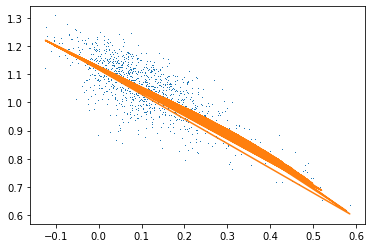

In [30]:
polyfunc = np.poly1d(pf)
plt.plot(cos_sims, eu_dists, ',')
plt.plot(cos_sims, polyfunc(cos_sims), '-')

In [14]:
# eu_dists_fit = (0.04471114)*cos_sims**3 + (0.0740919)*cos_sims**2 + (-0.74640201)*cos_sims + (0.95066707)
# plt.plot(eu_dists, eu_dists_fit, '.')

Ouch. Just using PCA at all messes with the distance relationship substantially.
And it gets much worse down at the 10-component level where we want to operate. 

At least the correlation kinda works at low distances. If we are able to get close, we could probably find the target still. But the early moves will not give good information at all. Unacceptable.

Got significantly improvement by normalizing all vectors prior to applying PCA. Now the full PCA correlates perfectly, and the lower-rank approximations work well enough on GLoVe.

Not as much luck on this Google dataset though. Ugh, 300 vectors? And what is with these garbage words? Man... quality really went out the window with this big data stuff.

In [ ]:
for n_dims in [20, 40, 60, 100, 200, 300]:
    w_list = list(w_vecs.keys())
    mat = do_pca(w_vecs, n_dims)
    cos_dists, eu_dists = rand_vs_rand(w_list, w_vecs, mat)
    plot_dist_relationship(cos_dists, eu_dists, n_dims)